<h1>Quantum yield plot file</h1>
<p>This notebook file is used to read the Ncm file that is generated from the cmscript.py, and analyze it. It can generate a transition density, and if experimental data is included it can fit the calculated data to the quantum yield plots.</p>
<p>The first cell loads the modules and defines the functions. The second cell loads the Ncm file and experimental data into memory. The third cell can then plot the data.</p>
<p>In order to make a quantum yield plot, you will need to do the following things: 1) Make sure the path to the cmscript.py file is correct in cell1. (In same directory as this notebook by default). 2) Set input in cell 2: directory of experimental data and calculated data. 3) plot the data in cell 3. </p>

<h3>Cell 1: Modules and functions</h3>
<p>Required action: define path to cmscript.py</p>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from scipy.interpolate import interp1d
from matplotlib.ticker import (MultipleLocator)
import matplotlib
from matplotlib.gridspec import GridSpec
import yaml

# This notebook uses some functions from the cmscript. If the cmscript.py is in your directory you don't have to specify a path.
# path = os.path.abspath('')
# path = os.path.abspath('').strip('Data')+'Testing'
# print(path)
# path = "C:\\Users\\Sven\\OneDrive\\Studie\\Master\\Jaar 2\\Thesis\\Python scripts\\Testing"    # Define a path to the cmscript if it is not in this directory
# sys.path.append(path)

from cmscript import find_CMcount

#########################################################################
# Functions thres(), ke() and QY() are needed for CM efficiency 
# Based on model from: DOI: 10.1021/nl101490z (Beard et al.)

kcool = 100 # Dummy value for kcool. It will cancel out in the equations
def thres(m, P, Eg):
    n = P/(1+P)
    return Eg*(1+m/n)
    #return Eg*2

def ke(Ex, i, m, P, Eg):
    O_fac = 1
    if i == 0:
        return 1
    if Ex < thres(i,P, Eg):
        O_fac = 0
    return (kcool*P*((Ex-thres(i,P, Eg))/thres(i,P, Eg))**2) * O_fac

def QY(E, n):
    P = n/(1-n)
    QY = np.zeros(len(E))
    for ix,Ex in enumerate(E):
        summation = []
        global Eg
        m = int((Ex/Eg))
        for j in range(1,m+1):
            product_top = []
            product_bot = []
            for i in range(1,j+1):
                #print(m,j,i)
                product_top.append(ke(Ex,i-1,m,P, Eg))
                product_bot.append(kcool + ke(Ex,i,m,P, Eg))
            product_top = np.prod(product_top)
            product_bot = np.prod(product_bot)
            summation.append(( j * kcool * product_top ) / product_bot)
        QY[ix] = sum(summation)
    return QY

#########################################################################
# Functions needed to plot experimental data
# Needed for string formatting
def conv(x):
    return x.replace(',', '.').encode()

# This function reads experimental data from a .csv file and returns an array.
# If plot is set to True, it will plot the experimental data
# The directory parameter is the path to the .csv file that contains experimental data
# ax is the axis object in which the data is going to be plotted 
# Set is_percentage to True if quantum yield is given as a percentage
def plot_expdata(directory, Eg, is_percentage=False, in_eV=True, plot=True,plot_attributes = True,ax=None,label='experimental',**kwargs):
    factor = 1
    if is_percentage:
        factor = 100
    
    data = np.genfromtxt((conv(x) for x in open(directory)), delimiter=';')
    xn = data[:,0]
    if not in_eV:
        xn = xn*Eg
    yn = data[:,1]/factor
    
    # Fits the experimental data to CM efficiency model from previous section
    popt, pcov = curve_fit(QY,xn,yn, bounds=(0,0.99999999))
    print(f'Experimental efficiency:\t{popt}')
    E = np.linspace(Eg,5,500)

    if plot:
        if plot_attributes:
            ax.plot(E, QY(E, 0.9999999999999999),'-.',color='grey',lw=1,label='n = 1')        # 100% efficiency fit
            ax.plot(E, QY(E, *popt),'b-.',lw=1,label=f'n = {round(popt[0],2)}')   # Calculated efficiency fit
        ax.scatter(xn,yn, label = label,**kwargs)
    expdata = np.zeros([len(xn),2])
    expdata[:,0] = xn
    expdata[:,1] = yn
    
    return expdata

#########################################################################
# The following functions are used to calculate the quantum yield from the number of CM transitions (Ncm)

# This function loads the relevant data in order to calculate the quantum yield
# directory is the absolute path to the directory that contains the Ncm.csv file and reduced_energies.csv file.
# Eg is the band gap that was given as input (should match experimental band gap for best results)
# dE is the 'energy pocket' in which you calculate the average probability. 
# Averaging is used to calculate the average Rcm/Rcool. This should be false when making the quantum yield
# plot, but True when you want to obtain the Rcm/Rcool as a function of energy.
# The CMcount array that is returns has the following structure: 
#column 1: Energy, column 2: Ncm for electrons, column 3: Ncm for holes 
def load_data(directory, Eg, dE, Emax, averaging=False):
    Ncm = np.genfromtxt(os.path.join(directory, 'Ncm.csv'), delimiter=',')
    energies = np.genfromtxt(os.path.join(directory, 'reduced_energies.csv'), delimiter=' ')
    nkpt = len(Ncm)
    Ntotal = sum(sum(Ncm))
    print(f'{directory}: \nTotal Ncm:\t{Ntotal}\nNkpt\t{nkpt}\nEg:\t{Eg}\ndE:\t{dE}')
    CMcount = find_CMcount(energies,Ncm,Emax=Emax,dE=dE,degenerate=True,averaging=averaging)
    return nkpt, CMcount

# Calculate probability from Ncm and Rcool/Rcm (this is the RR variable)
def P(Ncm, RR):
    return Ncm/(Ncm + RR)

# This is the main function. The input is the CMcount array and the Rcool/Rcm rate for electrons and holes.
# Although it is possible to fit the Rcool/Rcm for electrons and holes independently, the curve fitting function
# only uses a single fitting parameter that is used for both electrons and holes.
# The Emax value is the maximum photon energy that you want to include.
# dE is again the size of the 'energy pocket'.
# The array qyield is returned and has the following structure:
# col0: energy, col1: CM probability electrons, col2: holes, col3: quantum yield, col4: fraction of CM states electrons,
# col5: fraction of CM states holes.
def Ncm2QY(CMcount,RRe,RRh,Emax=4,dE=0.1):
    df = pd.DataFrame(CMcount,columns=['E','Ne','Nh'])
    Emin = df.iloc[0]['E']
    E = np.arange(Emin, Emax, dE)
    Pe = np.zeros(E.shape)
    fe = np.zeros(E.shape)
    Ph = np.zeros(E.shape)
    fh = np.zeros(E.shape)

    for ix,Ex in enumerate(E):
        Erange = (Ex-dE/2, Ex+dE/2)
        Ncme = df[df['E'].between(*Erange)]['Ne'].to_numpy()
        Ncmh = df[df['E'].between(*Erange)]['Nh'].to_numpy()
        if len(Ncme) == 0:
            Pe[ix] = 0
            fe[ix] = 0
        if len(Ncmh) == 0:
            Ph[ix] = 0
            fh[ix] = 0
        else:
            Pe[ix] = P(Ncme,RRe).mean()
            fe[ix] = np.count_nonzero(P(Ncme,RRe))/len(Ncme)
            Ph[ix] = P(Ncmh,RRh).mean()
            fh[ix] = np.count_nonzero(P(Ncmh,RRh))/len(Ncmh)
        
    qyield = np.zeros([len(E),8])
    qyield[:,0] = E
    qyield[:,1] = Pe
    qyield[:,2] = Ph
    qyield[:,3] = 1 + Pe + Ph
    qyield[:,4] = fe
    qyield[:,5] = fh
    
    return qyield

# This function reads the CMcount and generates a CM transition density plot
def generate_density(CMcount):
    import scipy as sc
    df = pd.DataFrame(CMcount, columns=['E','Electrons', 'Holes'])
    df = df.join( pd.Series(df['Electrons']+df['Holes'],name='Total') )
    plots = ['Electrons', 'Holes', 'Total']
    
    E = np.linspace(0,4,500)
    density = np.zeros([3, len(E)])
    for ix, carrier in enumerate(plots):
        Ncm = df[df[carrier]>0]['E']
        weights = df[df[carrier]>0][carrier]
        kde = sc.stats.gaussian_kde(Ncm, weights=weights)
        kde.covariance_factor = lambda : .1
        kde._compute_covariance()
        density[ix,:] = kde(E)
        density[ix,:] *= df[carrier].sum() / df['Total'].sum() # multiply density with filesize to obtain abs number of transitions
    fig, ax = plt.subplots()
    ax.plot(E,density[0],label='CB')
    ax.plot(E,density[1],label='VB')
    ax.plot(E,density[2],label='Averaging P',color='black')
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.set_title('CM transition density')
    ax.set_xlim(2,4)
    #plt.grid()
    ax.set_xlabel('$h\\omega$ (eV)')
    ax.set_ylabel('Transition density')
    ax.legend(loc=2)
    
    return E, density

def decorate(ax,xlabel, ylabel,fontsize=16, labelsize = 12):
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize =fontsize)
    ax.tick_params(axis='both', which='both', labelsize=labelsize)
    ax.legend(loc=2,fontsize=12)


<h3>Cell 2: Load experimental data and calculated data in memory</h3>
<p>Required action: define path to output files from cmscript.py (Ncm.csv and reduced_energies.csv) and give input variable dE</p>

In [2]:
# Input
# directory = '12x12x6_0.90eV_30Ha'                     # Path to directory containing Ncm.csv and reduced_energies.csv
directory = './abinit_example'                     # Path to directory containing Ncm.csv and reduced_energies.csv
dE = 0.1                                                             # Size of 'energy pockets' in which the average probability is going to be calculated
cm_input_file = './cm_input.yaml'                  # This is where the maximum photon energy and band gap are defined
expdata_path = r"Literature_Data/MoTe2_dataset.csv"  # path to experimental data
percentage = True                                                      # Is exp data in percentage?
in_eV= True                                                            # Is exp data in eV? False if it is in bandgap multiples
#########################################################################
# Find input parameters from cm_input.yaml
with open (cm_input_file,'r') as infile:
    input_data = yaml.safe_load(infile)
Emax = input_data.get('Emax')
Eg = input_data.get('TrueBG')
# Loading data
nkpt, CMcount = load_data(directory, Eg, dE, Emax)
#OneDrive/Studie/Master/Jaar 2/Thesis/Python scripts/Data/Analysis/example_analysis/12x12x6_0.85eV_30Ha/bulk_1o_GSR.nc
# # Load,experimental data
expdata = plot_expdata(expdata_path, Eg, is_percentage=percentage, in_eV=in_eV, plot=False)

# Fit calculated data to experimental data
print(f'Calculated data with Eg = {Eg}')
xn = expdata[:,0]
yn = expdata[:,1]
xn[8] +=  0.000001     # needed for the fit, since curve_fit cannot handle two similar values
xn[11] += 0.000001     # needed for the fit, since curve_fit cannot handle two similar values
xn[-1] += 0.000001     # needed for the fit, since curve_fit cannot handle two similar values

# Input function for curve fit. It will calculate the quantum yield and linearly interpolates the datapoints. 
# This interpolated data is then the function that will be fitted to the experimental data. 
# It requires the Rcool/Rcm for electrons and holes as input. The appropriate values will be determined in the curve_fit function
# using a least squares method.
# Note that in this analysis only a single fitting parameter is used and therefore we use RRe as input twice.
def qyfunction(E,RRe,RRh):
    qyield = Ncm2QY(CMcount,RRe,RRe,Emax=Emax,dE=dE)
    #qyield = Ncm2QY(CMcount0,RRe,RRh,Emax=Emax,dE=dE)  # This calculates the qyield with two fitting parameters
    interpolate = interp1d(qyield[:,0], qyield[:,3])    # This interpolation 
    return interpolate(E)

RR, pcov = curve_fit(qyfunction,xn[:-2],yn[:-2],bounds=(1,np.inf))   # Fit the interpolated quantum yield to the experimental data. Bounds are from 1 to infinity
print(f'Found rates:\nCB:\t{RR[0]}\nVB:\t{RR[1]}\npcov:\t {pcov}')
qyield = Ncm2QY(CMcount,RR[0],RR[0],Emax=Emax,dE=dE)                # Use the fitting parameters obtained (in this case with a single fitting parameter)
#qyield = Ncm2QY(CMcount0,RR[0],RR[1],Emax=Emax,dE=dE)               # For two fitting parameters

# Calculate the average rates Rcm/Rcool rates
nkpt, CMcount_avg = load_data(directory, Eg, dE, Emax, averaging=True)

print('All data is loaded')

./abinit_example: 
Total Ncm:	13198176.0
Nkpt	64
Eg:	0.9
dE:	0.1


100%|████████████████████████████████████████| 64/64 [00:00<00:00, 2115.08it/s]

Experimental efficiency:	[0.93091348]
Calculated data with Eg = 0.9


Found rates:
CB:	1.0000000000001414
VB:	2.0
pcov:	 [[728.12626303   0.        ]
 [  0.           0.        ]]
./abinit_example: 
Total Ncm:	13198176.0
Nkpt	64
Eg:	0.9
dE:	0.1


100%|████████████████████████████████████████| 64/64 [00:00<00:00, 2275.26it/s]

All data is loaded


<h3>Cell 3: Plot data</h3>
<p>Required action: Format plots to your liking</p>

 Input:
./abinit_example
Emax:	4
Eg:	0.9
dE:	0.1
Experimental efficiency:	[0.93091348]


Text(0, 0.5, 'Average $R_{cm} / R_{cool}$')

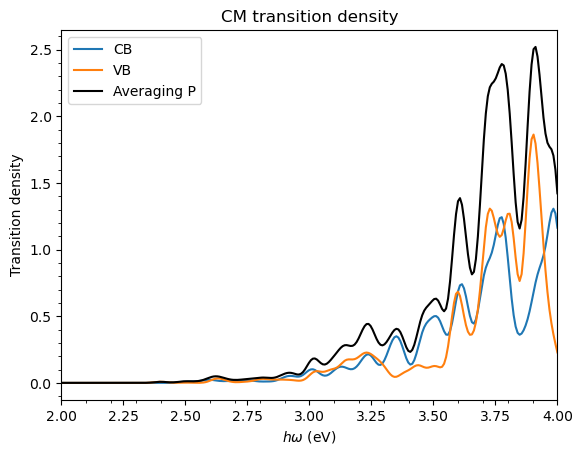

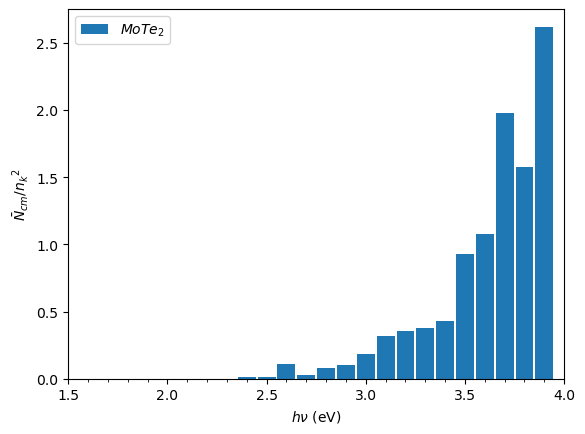

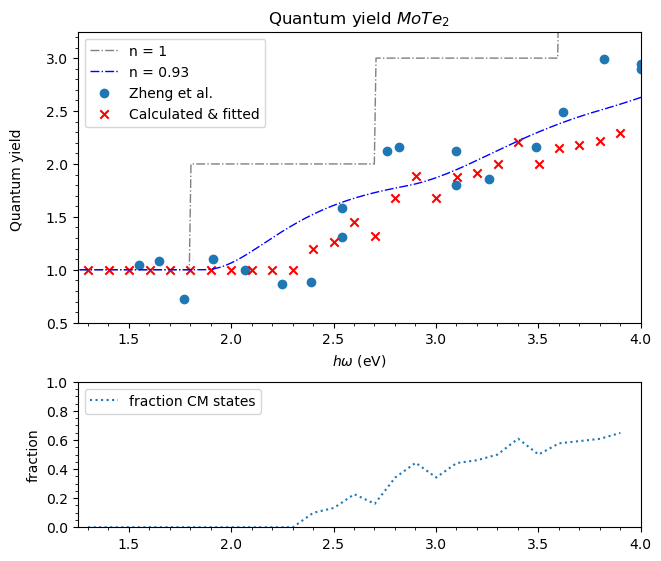

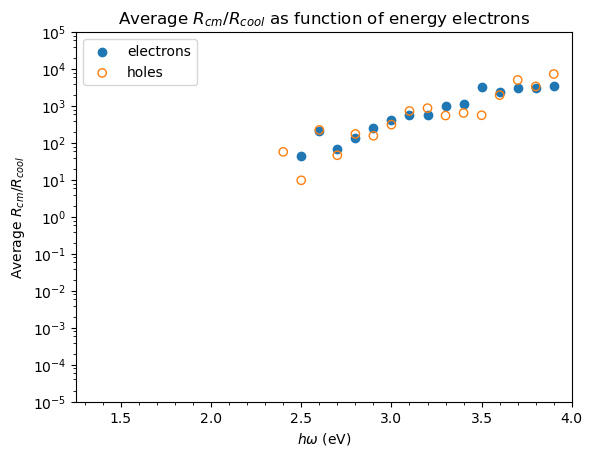

In [3]:
print(f' Input:\n{directory}\nEmax:\t{Emax}\nEg:\t{Eg}\ndE:\t{dE}')
#########################################################################
# Density plot

E, density_M = generate_density(CMcount)

#########################################################################
fig, ax = plt.subplots()
ax.bar(CMcount_avg[:,0], (CMcount_avg[:,1]+CMcount_avg[:,2])/(nkpt)**2, width=(dE-0.01), alpha=1, zorder=1, label='$MoTe_2$')
ax.set_ylabel(r'$\bar{N}_{cm} / {n_k}^2$')
ax.set_xlabel(r'$h\nu$ (eV)')
ax.set_xlim(1.5,4)
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.legend(loc=2)

#########################################################################
# Quantum yield plot
# Define figure
fig = plt.figure(constrained_layout=True, figsize=(6.5,5.5))
gs = GridSpec(2,1,height_ratios=(4,2), hspace=0, figure=fig)
ax1 = fig.add_subplot(gs[0,:]) # For quantum yield plot
ax2 = fig.add_subplot(gs[1,:]) # For fraction of states

# Plot experimental quantum yield data
expdata = plot_expdata(expdata_path, Eg, True, ax=ax1, plot=True, label='Zheng et al.')

# Plot calculated and fitted data
ax1.scatter(qyield[:,0],qyield[:,3],marker='x',color='r', label='Calculated & fitted')

# Plot fraction of CM states
ax2.plot(qyield[:,0],(qyield[:,4]+qyield[:,5])/2,':',label='fraction CM states')
ax2.set_ylabel('fraction')

# Decorate figure
ax1.set_title('Quantum yield $MoTe_2$')
ax1.set_xlabel('$h\\omega$ (eV)')
ax1.set_ylabel('Quantum yield \n')
ax1.legend(loc=2)
ax1.set_xticks(np.arange(1,4.5,0.5))
ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(MultipleLocator(0.1))
ax1.set_xlim(1.25,4)
ax1.set_ylim(0.5,3.25)

ax2.set_xlim(1.25,4)
ax2.xaxis.set_minor_locator(MultipleLocator(0.1))
ax2.yaxis.set_minor_locator(MultipleLocator(0.05))
ax2.yaxis.set_major_locator(MultipleLocator(0.2))
ax2.set_ylim(0,1)
ax2.legend(loc=2)

## In case you want to plot other rates as well ##
# qyield2 = Ncm2QY(CMcount0,1E-5,1E-5,Emax=Emax,dE=dE)
# ax1.scatter(qyield2[:,0],qyield2[:,3],marker='*',s=28,color='green', label='$\\frac{Rcool}{Rcm}$ = $10^{-5}$')

# qyield3 = Ncm2QY(CMcount0,1E6,1E6,Emax=Emax,dE=dE)
# ax1.scatter(qyield3[:,0],qyield3[:,3],marker='*',s=28,color='purple', label='$\\frac{Rcool}{Rcm}$ = $10^6$')

#########################################################################
# Rcm/Rcool plot

# First calculate the average Rcm/Rcool rate from the average Ncm values:
Re = CMcount_avg[:,1]/RR[0]
Rh = CMcount_avg[:,2]/RR[0]
#Rh = CMcount_avg[:,2]/RR[1]  # In case two fitting parameters were used

fig, ax = plt.subplots()
ax.scatter(CMcount_avg[:,0],Re,label='electrons')
ax.scatter(CMcount_avg[:,0],Rh,facecolors='none',edgecolors='tab:orange',label='holes')
ax.set_title('Average $R_{cm} / R_{cool}$ as function of energy electrons')
ax.legend(loc=2)
ax.set_yscale('log')
ax.set_xlabel('$h\\omega$ (eV)')
ax.set_xlim(1.25,4)
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_ylim(1E-5,1E5)
#plt.grid(which='both')
ax.set_ylabel('Average $R_{cm} / R_{cool}$')